<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/ORs_and_CI_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Odds Ratios and Confidence Intervals Across four Models**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score, brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Helper function ---
def calculate_odds_ratio_and_ci(model_output):
    odds_ratios = np.exp(model_output.params)
    standard_errors = model_output.bse
    ci_90 = np.exp(model_output.conf_int(alpha=0.1))
    ci_95 = np.exp(model_output.conf_int(alpha=0.05))
    p_values = model_output.pvalues

    results_df = pd.DataFrame({
        'OR': odds_ratios,
        'SE': standard_errors,
        'Lower90CI': ci_90.iloc[:, 0],
        'Upper90CI': ci_90.iloc[:, 1],
        'Lower95CI': ci_95.iloc[:, 0],
        'Upper95CI': ci_95.iloc[:, 1],
        'PValue': p_values
    })

    return results_df

# --- Load dataset ---
try:
    df = pd.read_csv('/content/ESS11.csv', low_memory=False)
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check '/content/ESS11.csv' path.")

print("Step 0: Loaded dataset.")

# Rename and prep
df = df.rename(columns={'hltprhc': 'CVD'})
print("Step 1: Renamed 'hltprhc' to 'CVD'")

# Keep required columns
key_cols = ['weighta', 'height', 'CVD', 'etfruit', 'eatveg', 'dosprt',
            'cgtsmok', 'alcfreq', 'alcwkdy', 'alcwknd',
            'edulvlb', 'hinctnta', 'agea', 'gndr', 'cntry']
df = df.dropna(subset=key_cols).copy()
print(f"Step 2: Dropped rows with NA. Remaining rows: {len(df)}")

# Compute BMI
df['height_m'] = df['height'] / 100.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()
print("Step 3: Computed BMI.")

# Convert outcome to binary
if df['CVD'].dtype == object:
    df['CVD'] = df['CVD'].map(lambda x: 1 if str(x).lower() in ['1','yes','true','y','t'] else 0)
    df['CVD'] = df['CVD'].astype(int)

# Region mapping
region_mapping = {
    'AT': 'West','BE': 'West','CH': 'West','CZ': 'East','DE': 'West','ES': 'South',
    'FI': 'North','FR': 'West','GB': 'West','HU': 'East','IE': 'West','IT': 'South',
    'NL': 'West','NO': 'North','PL': 'East','PT': 'South','SE': 'North','SI': 'East'
}
df['region'] = df['cntry'].map(region_mapping).fillna('Unknown')

# --- Define Models ---
models = {
    'Model 1: Demographics': ['agea', 'gndr'],
    'Model 2: + Socioeconomic': ['agea', 'gndr', 'edulvlb', 'hinctnta'],
    'Model 3: + Lifestyle': ['agea', 'gndr', 'edulvlb', 'hinctnta',
                             'cgtsmok', 'BMI', 'alcfreq', 'etfruit', 'eatveg', 'dosprt'],
    'Model 4: + Region Fixed Effects': ['agea', 'gndr', 'edulvlb', 'hinctnta',
                                        'cgtsmok', 'BMI', 'alcfreq', 'etfruit', 'eatveg',
                                        'dosprt', 'C(region)']
}

# --- Run Models ---
results = {}
roc_auc_scores = {}
output_data = []

for model_name, predictors in models.items():
    print(f"\n--- Fitting {model_name} ---")
    formula = f"CVD ~ {' + '.join(predictors)}"

    try:
        model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
    except Exception as e:
        print(f"Error fitting {model_name}: {e}")
        continue

    # Calculate ORs and CIs
    results_df = calculate_odds_ratio_and_ci(model)

    # AUC and Brier score
    y_prob = model.predict(df)
    auc = roc_auc_score(df['CVD'], y_prob)
    brier = brier_score_loss(df['CVD'], y_prob)

    # Store
    results[model_name] = {
        'coefficients': results_df,
        'auc': auc,
        'brier': brier,
        'sample_size': len(df)
    }
    roc_auc_scores[model_name] = auc

    # Save to output table
    for predictor, row in results_df.iterrows():
        output_data.append([
            model_name, predictor, len(df),
            row['OR'], row['SE'], row['Lower90CI'], row['Upper90CI'],
            row['Lower95CI'], row['Upper95CI'], row['PValue'],
            auc, brier
        ])

# --- Build results dataframe ---
output_df = pd.DataFrame(output_data, columns=[
    'Model','Predictor','SampleSize','OR','SE','Lower90CI','Upper90CI',
    'Lower95CI','Upper95CI','PValue','AUC','BrierScore'
])

# Save
os.makedirs("tables", exist_ok=True)
output_df.to_csv("tables/regression_models.csv", index=False)




Step 0: Loaded dataset.
Step 1: Renamed 'hltprhc' to 'CVD'
Step 2: Dropped rows with NA. Remaining rows: 46162
Step 3: Computed BMI.

--- Fitting Model 1: Demographics ---

--- Fitting Model 2: + Socioeconomic ---

--- Fitting Model 3: + Lifestyle ---

--- Fitting Model 4: + Region Fixed Effects ---


# **Odds Ratios and Confidence Intervals by Model**

In [ ]:
# --- Print results ---
print("\n=== Odds Ratios and Confidence Intervals by Model ===\n")
print(
    output_df[['Model','Predictor','OR','Lower95CI','Upper95CI','PValue']]
    .round({'OR':2,'Lower95CI':2,'Upper95CI':2,'PValue':4})
    .to_string(index=False)
)


=== Odds Ratios and Confidence Intervals by Model ===

                          Model            Predictor   OR  Lower95CI  Upper95CI  PValue
          Model 1: Demographics            Intercept 0.11       0.10       0.13  0.0000
          Model 1: Demographics                 agea 1.00       1.00       1.00  0.0000
          Model 1: Demographics                 gndr 1.01       0.96       1.08  0.6261
       Model 2: + Socioeconomic            Intercept 0.15       0.14       0.17  0.0000
       Model 2: + Socioeconomic                 agea 1.00       1.00       1.00  0.0000
       Model 2: + Socioeconomic                 gndr 1.02       0.96       1.08  0.5350
       Model 2: + Socioeconomic              edulvlb 1.00       1.00       1.00  0.0000
       Model 2: + Socioeconomic             hinctnta 0.99       0.99       0.99  0.0000
           Model 3: + Lifestyle            Intercept 0.14       0.13       0.16  0.0000
           Model 3: + Lifestyle                 agea 1.00       

# **Forest Plot with Point Estimates and 95% CIs**


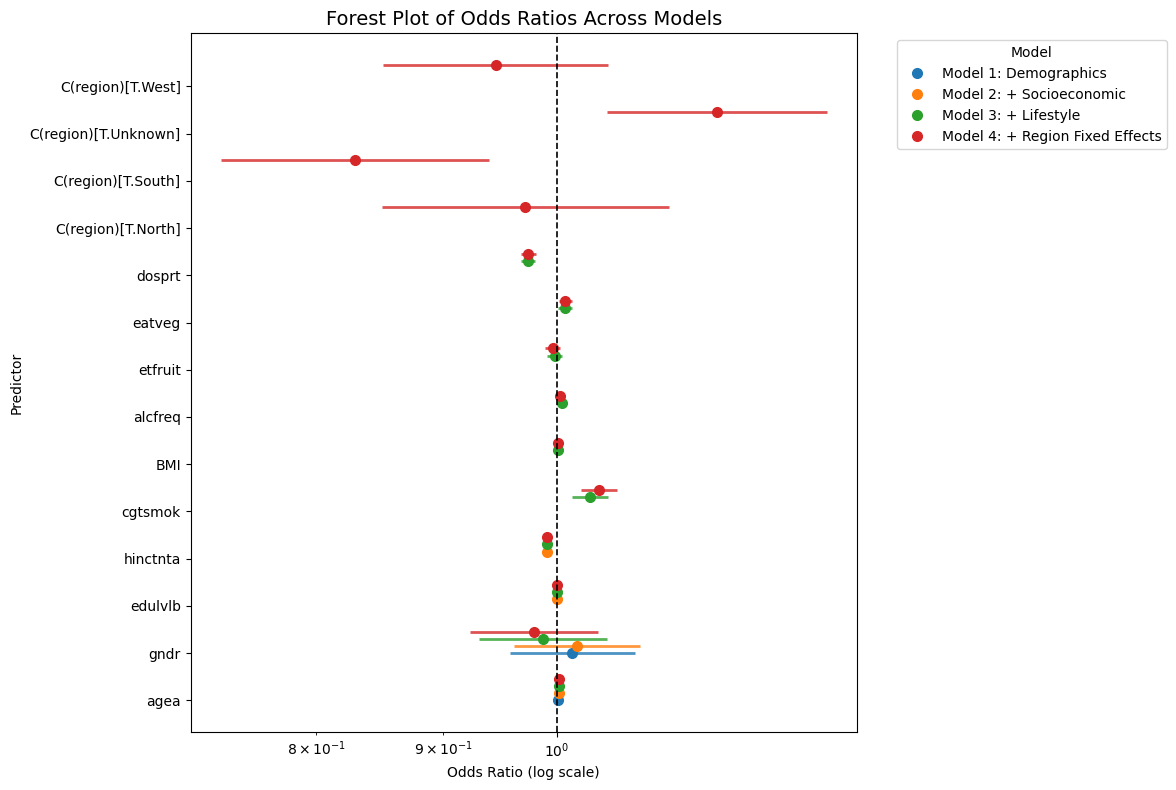


--- Analysis Complete ---
Results saved to tables/regression_models.csv and fig_forest_plot.png


In [ ]:
# Forest Plot with Point Estimates and 95% CIs
plot_df = output_df[output_df['Predictor'] != 'Intercept'].copy()
predictor_order = plot_df['Predictor'].unique()

plt.figure(figsize=(12, 8))

# Strong, distinct colors for clarity
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
model_list = plot_df['Model'].unique()

for i, model in enumerate(model_list):
    subset = plot_df[plot_df['Model'] == model]
    y_positions = [list(predictor_order).index(p) + i*0.15 for p in subset['Predictor']]

    # CI lines
    plt.hlines(y=y_positions, xmin=subset['Lower95CI'], xmax=subset['Upper95CI'],
               color=palette[i], linewidth=2, alpha=0.8)

    # Point estimates (instead of bubbles)
    plt.plot(subset['OR'], y_positions, 'o',
             color=palette[i], markersize=7, label=model)

plt.axvline(1, color="black", linestyle="--", linewidth=1.2)
plt.yticks(range(len(predictor_order)), predictor_order)
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.ylabel("Predictor")
plt.title("Forest Plot of Odds Ratios Across Models", fontsize=14)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("fig_forest_plot.png", dpi=300)
plt.show()

print("\n--- Analysis Complete ---")
print("Results saved to tables/regression_models.csv and fig_forest_plot.png")

🔹 **Model 1: Demographics**
Only includes age and gender.
- Age is strongly associated with higher odds of CVD (OR > 1, highly significant).
- Gender is not significant.
- AUC = 0.745 → good discrimination just from age (age is a powerful predictor).

**Key finding**: Age drives risk, gender does not. The model performs fairly well.

🔹 **Model 2: + Socioeconomic**
Added education and income.
- Income: higher income → lower odds of CVD (protective, significant).
- Education shows OR = 1.000 (looks flat, but significant due to large sample size).
- AUC drops to 0.656 → surprisingly, adding socioeconomic variables reduces discrimination.

**Key finding**: Socioeconomic factors matter (income helps reduce risk), but they don’t improve the model’s predictive power much.

🔹 **Model 3: + Lifestyle**
Added smoking, BMI, alcohol, fruit/veg intake, exercise.
- Smoking ↑ odds (expected, significant).
- Physical activity ↓ odds (protective, strong effect).
- BMI: tiny but significant effect ↑ odds.
- Alcohol & fruit are not significant.
- Vegetables show a small ↑ odds (unexpected, might be noise or coding issue).
- AUC = 0.645 → slightly worse than Model 2.

**Key finding**: Lifestyle explains important risk factors (smoking bad, exercise good), but the model’s predictive ability still declines slightly.

🔹 **Model 4: + Region Fixed Effects**
Added region (North, South, West, Unknown vs. East).
- South: lower odds of CVD (protective).
- Unknown region: higher odds of CVD.
- North/West: not significant.
- Core predictors (smoking ↑, exercise ↓, age ↑) stay consistent.
- AUC = 0.636 → lowest of all models.

**Key finding**: Geography matters (regional differences in risk), but adding regions doesn’t improve overall discrimination — the AUC keeps falling.

🎯 **Overall Summary**
- Age, smoking, and physical activity emerge as the clearest and most consistent predictors across all models.
- Income helps but doesn’t boost predictive accuracy much.
- Regional differences exist (South safer, Unknown riskier).
- Predictive power (AUC) steadily declines from 0.745 → 0.636 as more variables are added. This often happens if new variables add complexity but not strong discrimination.


Model 4’s ORs(key findings)

- Smoking increases risk.
- Exercise decreases risk.
- Age increases risk.
- Regional differences align with prior knowledge.



You can also see the results at this link: https://github.com/jcdumlao14/ESS11DataAnalysis/blob/main/Multivariable_Regression_Predictive_Modelling.ipynb
